# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* Offers sent during 30-day test period (10 offers x 6 fields)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum money required spend to complete an offer
* reward (int) - reward given for completing an offer (money awarded for the amount spent)
* duration (int) - time for offer to be open, in days
* channels (list of strings) (web, email, mobile, social)

**profile.json**
* Rewards program users (17000 users x 5 fields)
* age (int) - age of the customer (missing value encoded as 118)
* became_member_on (int) - date when customer created an app account (format YYYYMMDD)
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* Event log (306648 events x 4 fields)
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
* offer id: (string/hash) not associated with any "transaction"
* amount: (numeric) money spent in "transaction"
* reward: (numeric) money gained from "offer completed"


**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
#print(portfolio.head())
#print(profile.head())
print(transcript.head())


                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  


# Exploratory Data Analysis

In [6]:
# Examine the first rows of portfolio
print(portfolio.head())

   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  


In [7]:
# Get information about the 'portfolio' dataset

print(portfolio.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes
None


In [8]:
# First rows of 'profile' dataset

print(profile.head())

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


In [9]:
# Get an overview of 'profile' dataset
print(profile.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


In [10]:
# Get the number of null values in 'profile' dataset
print(profile.isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [11]:
print(profile.describe(include='all'))

       gender           age                                id  \
count   14825  17000.000000                             17000   
unique      3           NaN                             17000   
top         M           NaN  68be06ca386d4c31939f3a4f0e3dd783   
freq     8484           NaN                                 1   
mean      NaN     62.531412                               NaN   
std       NaN     26.738580                               NaN   
min       NaN     18.000000                               NaN   
25%       NaN     45.000000                               NaN   
50%       NaN     58.000000                               NaN   
75%       NaN     73.000000                               NaN   
max       NaN    118.000000                               NaN   

        became_member_on         income  
count       1.700000e+04   14825.000000  
unique               NaN            NaN  
top                  NaN            NaN  
freq                 NaN            NaN  
mean     

In [7]:
# Count the occurences of each gender
gender_counts = profile['gender'].value_counts()
index = ['Male', 'Female', 'Other']
gender_counts.index = index
print(gender_counts)

Male      8484
Female    6129
Other      212
Name: count, dtype: int64


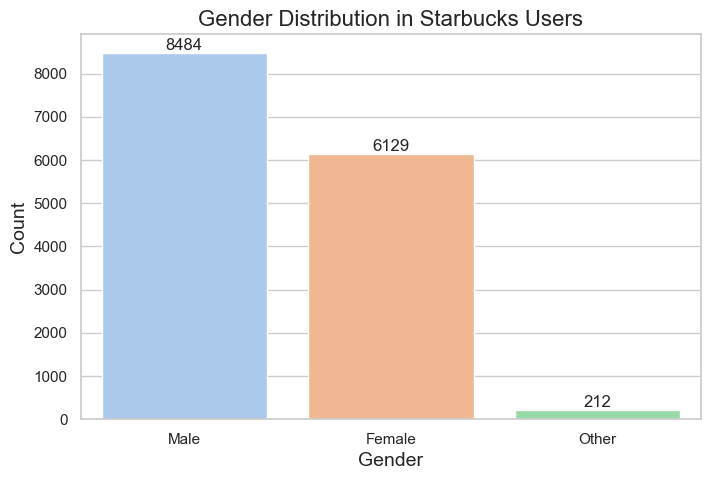

In [16]:
# Bar plot of 'Gender' in the  'profile' dataset

# Set the aesthetic style
sns.set(style = 'whitegrid')

# Create a bar plot
plt.figure(figsize = (8,5))
ax = sns.barplot(x = gender_counts.index, y = gender_counts.values, hue=gender_counts.index, palette = 'pastel')

# Titles and labels
plt.title('Gender Distribution in Starbucks Users', fontsize = 16)
plt.xlabel('Gender', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

for i in ax.containers:
    ax.bar_label(i,) 

plt.show()

In [8]:
 # Examine the the 'age' column of the dataset
print(profile['age'].value_counts())
print(sorted(profile['age'].unique()))

age
118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: count, Length: 85, dtype: int64
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 118]


In [9]:
# Replace '118' with 'NaN'
profile['age'] = profile['age'].replace(118, np.nan)

C:\Users\cerde\AppData\Local\Temp\ipykernel_6724\606730141.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = profile['age'], palette = 'pastel')


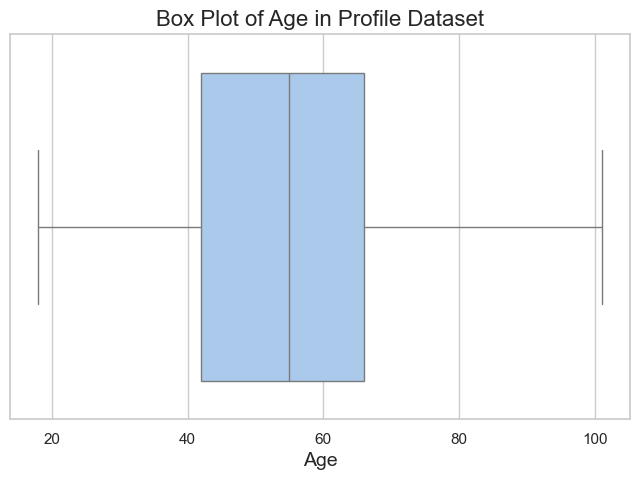

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [10]:
# Box Plot of  'age' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = profile['age'], palette = 'pastel')

# Titles and labels
plt.title('Box Plot of Age in Profile Dataset', fontsize=16)
plt.xlabel('Age', fontsize = 14)

# Show the plot
plt.show()

profile['age'].describe()

age
118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: count, Length: 85, dtype: int64
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 118]
